#Project: Text-to-SQL Agents with Step by step reasoning

In this project we utilize the Lang graph to query multiple SQL database tables and aggregate their results such that the agent

 - Extracts each thinking phase from reasoning tags
 - Formats the output in a readable way
 - Captures the final SQL query when generated
 - Shows the agent’s thought process in real-time
 - We can finally add plotting to this agent in future

 The entire architecture is shown below:

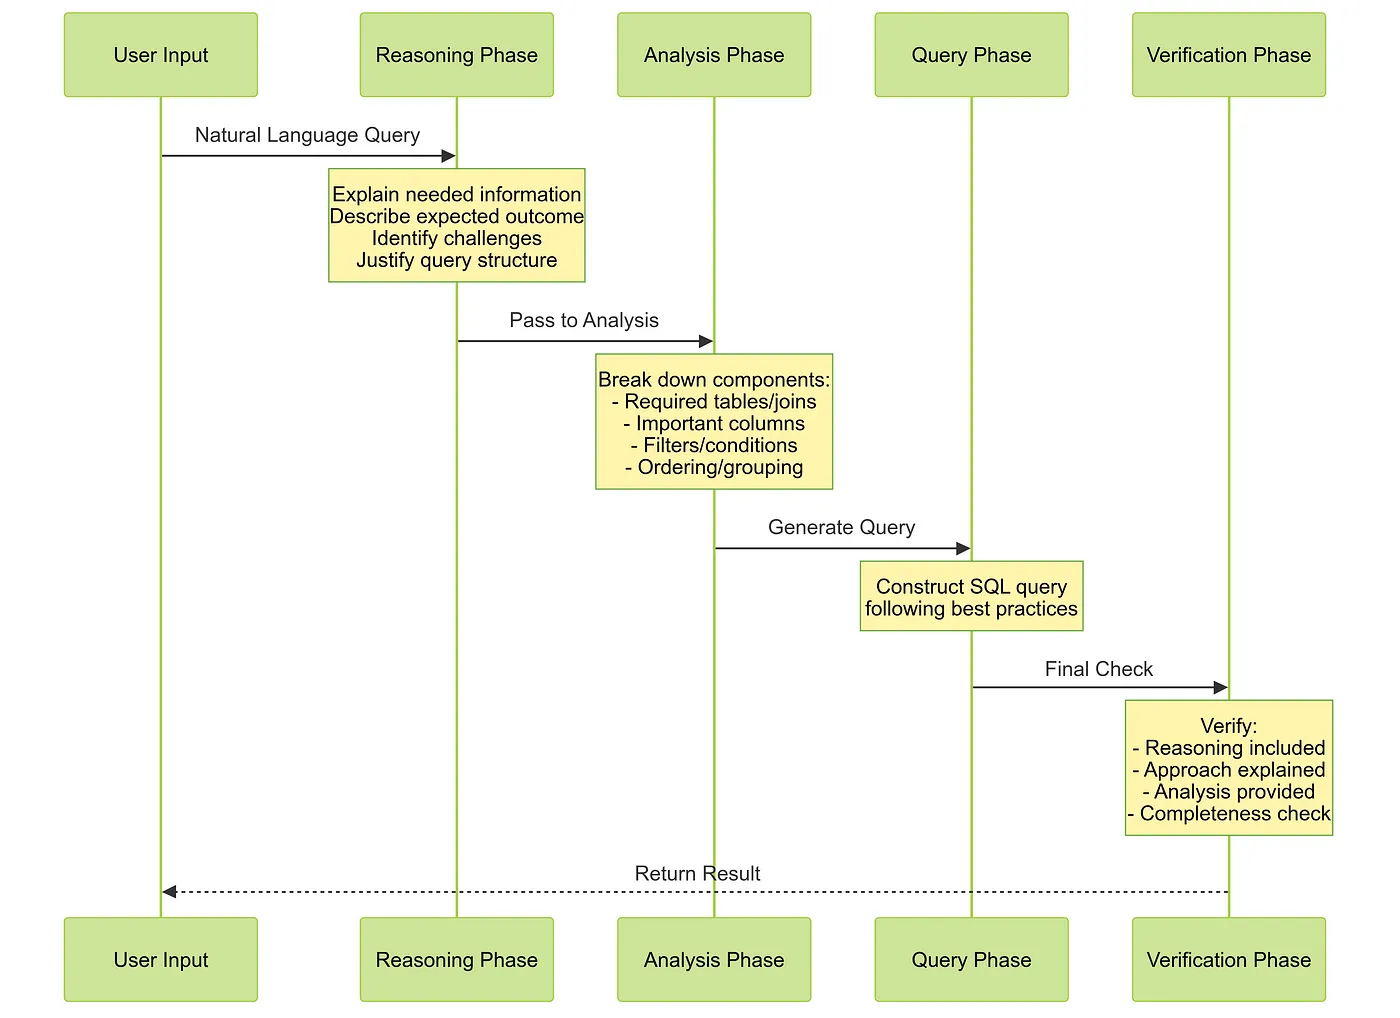

In [8]:
#!pip install langchain_community langchain langgraph
#!pip install langchain-openai

In [ ]:
import os
from typing import Dict, Any
import sqlite3
import re

from typing_extensions import TypedDict
from typing import Annotated, Optional
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

## Create a sample database and associated tables

In [2]:
def create_and_populate_db():
    # Connect to SQLite database (or create it if it doesn't exist)
    conn = sqlite3.connect("./data/artist_album.db")
    cursor = conn.cursor()

    # Create tables
    cursor.executescript('''
    CREATE TABLE IF NOT EXISTS Artist (
        ArtistId INTEGER PRIMARY KEY AUTOINCREMENT,
        Name TEXT NOT NULL
    );

    CREATE TABLE IF NOT EXISTS Album (
        AlbumId INTEGER PRIMARY KEY AUTOINCREMENT,
        Title TEXT NOT NULL,
        ArtistId INTEGER NOT NULL,
        FOREIGN KEY (ArtistId) REFERENCES Artist(ArtistId) ON DELETE CASCADE
    );

    CREATE TABLE IF NOT EXISTS Invoice (
        InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT,
        CustomerId INTEGER NOT NULL,
        Total REAL NOT NULL
    );

    CREATE TABLE IF NOT EXISTS InvoiceLine (
        InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT,
        InvoiceId INTEGER NOT NULL,
        TrackId INTEGER NOT NULL,
        UnitPrice REAL NOT NULL,
        Quantity INTEGER NOT NULL,
        FOREIGN KEY (InvoiceId) REFERENCES Invoice(InvoiceId) ON DELETE CASCADE
    );
    ''')

    # Insert data into Artist table
    cursor.executemany("""
    INSERT INTO Artist (Name) VALUES (?)
    """, [
        ('The Beatles',),
        ('Pink Floyd',),
        ('Led Zeppelin',),
        ('Queen',)
    ])

    # Insert data into Album table
    cursor.executemany("""
    INSERT INTO Album (Title, ArtistId) VALUES (?, ?)
    """, [
        ('Abbey Road', 1),
        ('The Dark Side of the Moon', 2),
        ('Led Zeppelin IV', 3),
        ('A Night at the Opera', 4)
    ])

    # Insert data into Invoice table
    cursor.executemany("""
    INSERT INTO Invoice (CustomerId, Total) VALUES (?, ?)
    """, [
        (1, 29.99),
        (2, 19.99),
        (3, 39.99)
    ])

    # Insert data into InvoiceLine table
    cursor.executemany("""
    INSERT INTO InvoiceLine (InvoiceId, TrackId, UnitPrice, Quantity) VALUES (?, ?, ?, ?)
    """, [
        (1, 101, 9.99, 1),
        (1, 102, 4.99, 2),
        (2, 103, 9.99, 1),
        (3, 104, 19.99, 2)
    ])

    # Commit changes and close connection
    conn.commit()
    conn.close()
    print("Database 'artist_album.db' created and populated successfully.")

if __name__ == "__main__":
    create_and_populate_db()

Database 'artist_album.db' created and populated successfully.


In [10]:
def _set_env(key: str):
    if key not in os.environ:
        os.environ['OPENAI_API_KEY'] = key

# Please set your key here
_set_env("OPENAI_KEY")

In [11]:
db_file = "/content/data/artist_album.db"
engine = create_engine(f"sqlite:///{db_file}")
db = SQLDatabase(engine=engine)

In [12]:
# Create the toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o-mini"))
sql_db_toolkit_tools = toolkit.get_tools()

### Prompt template

Design an elaborate prompt template that guides the reasoning. The sections include:
 - reasoning
 - analysis
 - query
 - error check
 - final check

In [13]:
query_gen_system = """
I am an SQL expert who helps analyze database queries. I have access to tools for interacting with the database. When given a question, I'll think through it carefully and explain my reasoning in natural language.

Then I'll walk through my analysis process:

1. First, I'll understand what tables and data I need
2. Then, I'll verify the schema and relationships
3. Finally, I'll construct an appropriate SQL query

For each query, I'll think about:
- What tables are involved and how they connect
- Any special conditions or filters needed
- How to handle potential edge cases
- The most efficient way to get the results

<reasoning>
I will **always** include this section before writing a query. Here, I will:
- Explain what information I need and why
- Describe my expected outcome
- Identify potential challenges
- Justify my query structure

If this section is missing, I will rewrite my response to include it.
</reasoning>

<analysis>
Here I break down the key components needed for the query:
- Required tables and joins
- Important columns and calculations
- Any specific filters or conditions
- Proper ordering and grouping
</analysis>

<query>
The final SQL query
</query>

<error_check>
If there's an error, I'll explain:
- What went wrong
- Why it happened
- How to fix it
</error_check>

<final_check>
Before finalizing, I will verify:
- Did I include a clear reasoning section?
- Did I explain my approach before querying?
- Did I provide an analysis of the query structure?
- If any of these are missing, I will revise my response.
</final_check>

Important rules:
1. Only use SELECT statements, no modifications
2. Verify all schema assumptions
3. Use proper SQLite syntax
4. Limit results to 10 unless specified
5. Double-check all joins and conditions
6. Always include tool_analysis and tool_reasoning for each tool call
"""


### Building the LangGraph SQL Agent.
 - We extract thinking phase from reasoning phases
 - Finally show real time thought process of the Agent

In [14]:

query_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", query_gen_system),
    MessagesPlaceholder(variable_name="messages"),
])

query_gen_model = query_gen_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0).bind_tools(tools=sql_db_toolkit_tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def query_gen_node(state: State):
    return {"messages": [query_gen_model.invoke(state["messages"])]}

checkpointer = MemorySaver()

graph_builder.add_node("query_gen", query_gen_node)
query_gen_tools_node = ToolNode(tools=sql_db_toolkit_tools)
graph_builder.add_node("query_gen_tools", query_gen_tools_node)

graph_builder.add_conditional_edges(
    "query_gen",
    tools_condition,
    {"tools": "query_gen_tools", END: END},
)

graph_builder.add_edge("query_gen_tools", "query_gen")
graph_builder.set_entry_point("query_gen")
graph = graph_builder.compile(checkpointer=checkpointer)

def format_section(title: str, content: str) -> str:
    if not content:
        return ""
    return f"\n{content}\n"

In [23]:
def extract_section(text: str, section: str) -> str:
    pattern = f"<{section}>(.*?)</{section}>"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(1).strip() if match else ""

def process_event(event: Dict[str, Any]) -> Optional[str]:
    if 'query_gen' in event:
        messages = event['query_gen']['messages']
        for message in messages:
            content = message.content if hasattr(message, 'content') else ""

            reasoning = extract_section(content, "reasoning")
            if reasoning:
                print(format_section("", reasoning))

            analysis = extract_section(content, "analysis")
            if analysis:
                print(format_section("", analysis))

            error_check = extract_section(content, "error_check")
            if error_check:
                print(format_section("", error_check))

            final_check = extract_section(content, "final_check")
            if final_check:
                print(format_section("", final_check))

            if hasattr(message, 'tool_calls'):
                for tool_call in message.tool_calls:
                    tool_name = tool_call['name']
                    if tool_name == 'sql_db_query':
                        return tool_call['args']['query']

            query = extract_section(content, "query")
            if query:
                sql_match = re.search(
                    r'```sql\n(.*?)\n```', query, re.DOTALL)
                if sql_match:
                    return format_section("", query)

    return None

In [24]:
def run_query(query_text: str):
    print(f"\nAnalyzing your question: {query_text}")
    final_sql = None

    for event in graph.stream({"messages": [("user", query_text)]},
                              config={"configurable": {"thread_id": 12}}):
        sql = process_event(event)
        if sql:
            final_sql = sql

    if final_sql:
        print(
            "\nBased on my analysis, here's the SQL query that will answer your question:")
        print(f"\n{final_sql}")
        return final_sql

In [25]:
def interactive_sql():
    print("\nWelcome to the SQL Assistant! Type 'exit' to quit.")

    while True:
        try:
            query = input("\nWhat would you like to know? ")
            if query.lower() in ['exit', 'quit']:
                print("\nThank you for using SQL Assistant!")
                break

            run_query(query)

        except KeyboardInterrupt:
            print("\nThank you for using SQL Assistant!")
            break
        except Exception as e:
            print(f"\nAn error occurred: {str(e)}")
            print("Please try again with a different query.")


In [26]:
if __name__ == "__main__":
    interactive_sql()


Welcome to the SQL Assistant! Type 'exit' to quit.

What would you like to know? What are the top 5 best-selling tracks by revenue?

Analyzing your question: What are the top 5 best-selling tracks by revenue?

To determine the top 5 best-selling tracks by revenue, I need to identify the relevant tables that contain information about tracks and their sales. Typically, this would involve a "tracks" table that includes track details and a "sales" or "revenue" table that records sales transactions.

My expected outcome is a list of the top 5 tracks sorted by their total revenue, which will help in understanding which tracks are the most profitable.

Potential challenges include ensuring that the revenue is correctly calculated and that the data is aggregated properly. I will need to join the relevant tables on the appropriate keys, likely using track IDs.

I will structure the query to:
1. Select the track name and total revenue.
2. Group the results by track.
3. Order the results by tota